## Machine Translation (English to French) - Version 2

This model will appear on my HuggingFace profile as: 'mbart-large-50-English_French_Translation'

Dataset Source: https://www.kaggle.com/datasets/hgultekin/paralel-translation-corpus-in-22-languages

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import DataCollatorForSeq2Seq, MBart50Tokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, set_seed

import datasets
from datasets import Dataset, DatasetDict

import evaluate

NOTE: Redirects are currently not supported in Windows or MacOs.


#### Versions of Software & Libraries Used

In [2]:
print("Transformers:".rjust(15), transformers.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("NumPy:".rjust(15), np.__version__)
print("Python:".rjust(15), sys.version[0:6]) 
print("Datasets:".rjust(15), datasets.__version__)

  Transformers: 4.26.1
        Pandas: 1.5.0
         NumPy: 1.24.2
        Python: 3.9.12
      Datasets: 2.9.0


#### Ingest & Start Preprocessing Data

In [3]:
data = pd.read_csv('EN-FR.txt', 
                   delimiter='\t', 
                   engine="c", 
                   header=None)

data.drop_duplicates(inplace=True)

data.dropna(inplace=True)

data[0] = data[0].str.strip()
data[1] = data[1].str.strip()

data.drop(columns=[2, 3, 4, 5, 6, 7], inplace=True)

data.rename(columns={1 : 'french', 0 : 'english'}, inplace=True)

data = data[~data['english'].str.contains('\\d', regex=True)] # Drop samples with numbers

data

,english,french
3,"THE COMMISSION OF THE EUROPEAN COMMUNITIES,","LA COMMISSION DES COMMUNAUTÉS EUROPÉENNES,"
4,Having regard to the Treaty establishing the E...,"vu le traité instituant la Communauté européenne,"
6,Whereas:,considérant ce qui suit:
8,The amount(s) of the processing securities mus...,Le ou les montants des garanties de transforma...
9,The measures provided for in this Regulation a...,Les mesures prévues au présent règlement sont ...
...,...,...
4015063,The exchange rates for the calculation of such...,Les taux de change utilisés pour le calcul de ...
4015067,Albania,"Afrique du Sud 69,0 Albanie"
4015068,Colombia,"Cisjordanie — Bande de Gaza 87,8 Colombie"
4015069,Romania,"République démocratique du Congo 140,9 Républi..."


#### Visual: Length of English Entries

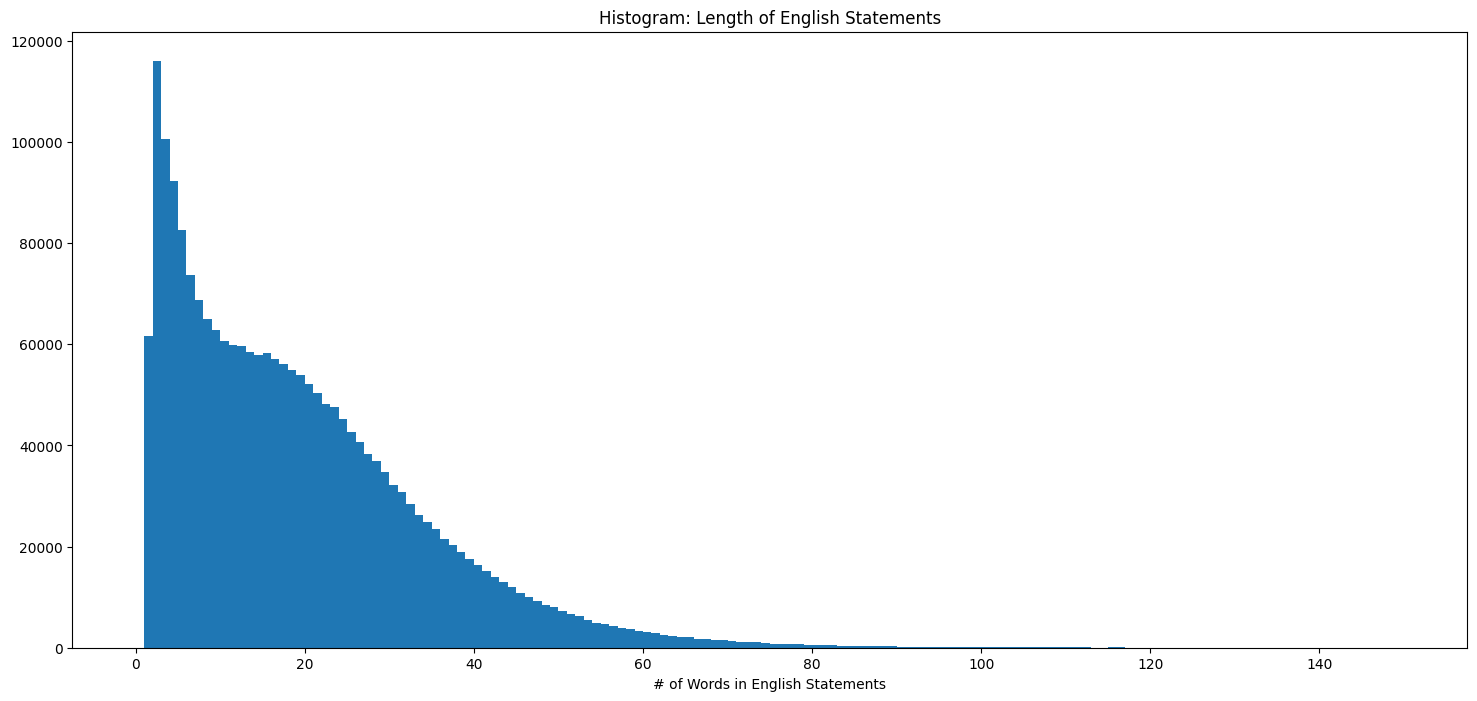

The Maximum length of English text (in words) is 278 words.


In [4]:
data['english_length'] = data['english'].str.split().str.len()

n_bin = 150
data.hist('english_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of English Statements')
plt.xlabel('# of Words in English Statements')
plt.show()

print(f"The Maximum length of English text (in words) is {max(data['english_length'])} words.")

#### Visual: Length of French Entries

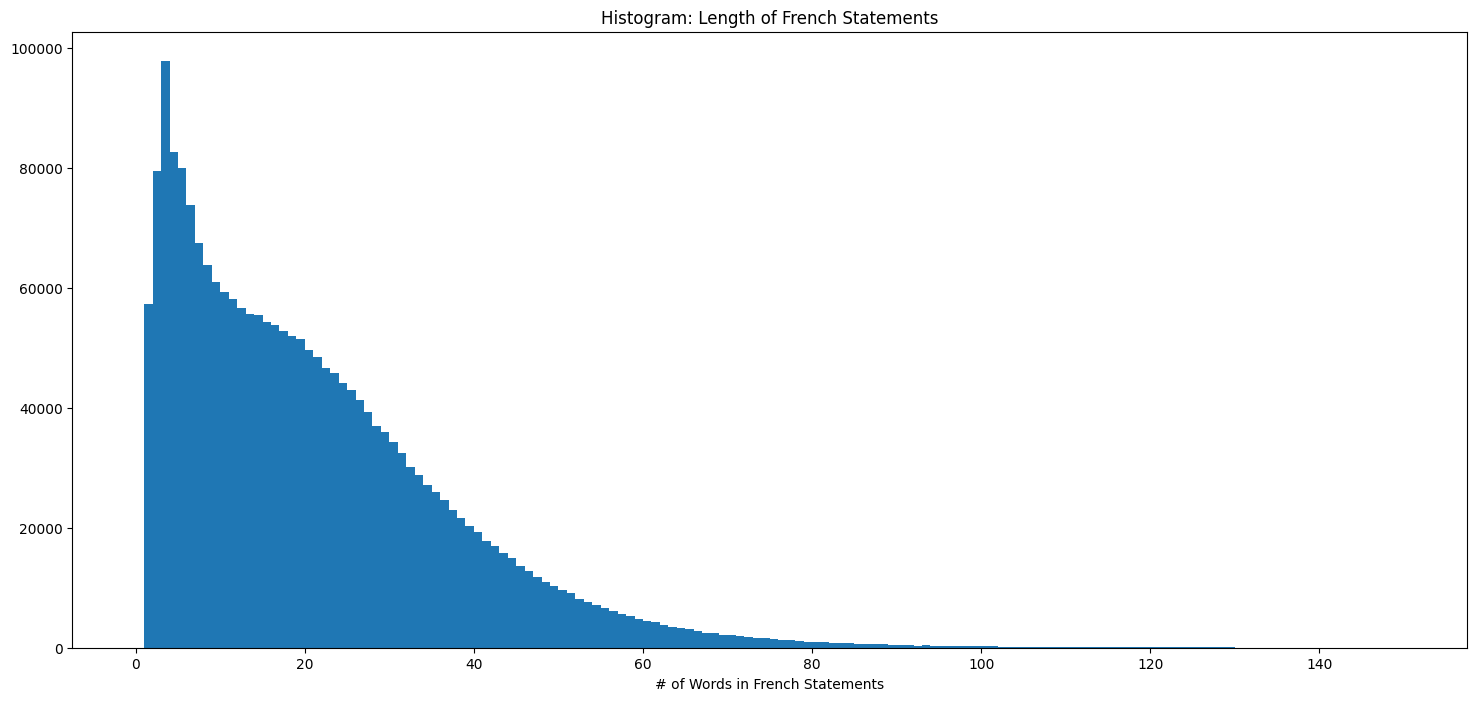

The Maximum length of French text (in words) is 354 words.


In [5]:
data['french_length'] = data['french'].str.split().str.len()

n_bin=150
data.hist('french_length', grid=False, range=(0,n_bin), figsize=(18,8), bins=n_bin)
plt.title('Histogram: Length of French Statements')
plt.xlabel('# of Words in French Statements')
plt.show()

print(f"The Maximum length of French text (in words) is {max(data['french_length'])} words.")

#### Trim Dataset Size & Drop Unnecessary Features

In [6]:
upper_limit = 46
lower_limit = 5

data = data[data['french_length'] < upper_limit] # make sure that the French text ...
data = data[data['french_length'] > lower_limit] # has between 6 & 45 words

data = data[data['english_length'] < upper_limit] # make sure that the English text ...
data = data[data['english_length'] > lower_limit] # has between 6 & 45 words

data['eng_char_length'] = data['english'].str.len() # add column with calculated character length
data['french_char_length'] = data['french'].str.len() # add column with calculated character length

data = data[data['eng_char_length'] > 30] # make sure that the text has over 30 characters...
data = data[data['french_char_length'] > 30] # ... for both languages

# reset the index
data.reset_index(drop=True, inplace=True)

# Remove columns that are no longer necessary
data.drop(columns=['french_length', 
                   'english_length', 
                   'eng_char_length', 
                   'french_char_length'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518294 entries, 0 to 1518293
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   english  1518294 non-null  object
 1   french   1518294 non-null  object
dtypes: object(2)
memory usage: 23.2+ MB


#### Randomly Sample 30,000 Samples (Due to Hardware Limitations)

In [7]:
data = data.sample(n=30000, random_state=42, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   english  30000 non-null  object
 1   french   30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB


#### Final Preprocessing

In [8]:
data.rename(columns={'english' : 'en', 'french' : 'fr'}, inplace=True)

all_data = data.to_dict(orient='records')
df = pd.Series(all_data)
df = pd.DataFrame(df)
df.rename(columns={ 0 : 'translation'}, inplace=True)
df.head()

,translation
0,{'en': 'The standard in question should be inc...
1,{'en': 'Analysis of value creation and profita...
2,{'en': 'Suspension or revocation of a medical ...
3,"{'en': 'Other tree and bush fruits and nuts', ..."
4,{'en': 'Automatic recognition of insolvency pr...


#### Convert to Dataset Format & Split into Train/Test/Eval Datasets

In [9]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)
ds['train'][25]

Training Dataset Shape: (24000, 1)
Testing Dataset Shape: (3000, 1)
Evaluation Dataset Shape: (3000, 1)


{'translation': {'en': 'The Member States concerned should, however, be allowed to lay down additional eligibility conditions so as to gear measures more closely to the national situation in the olive sector.',
  'fr': 'Toutefois, il convient de permettre aux États membres concernés de prévoir des conditions d’éligibilité supplémentaires afin de mieux adapter les actions aux réalités nationales du secteur oléicole.'}}

#### Remember to Install git lfs & Enter HuggingFace Access Token

In [10]:
# Enter Huggingface Access Token

!git lfs install

Git LFS initialized.


#### Basic Values/Constants

In [11]:
set_seed = 42
NUM_OF_EPOCHS = 1

BATCH_SIZE = 32
LEARNING_RATE = 2e-5

SOURCE_LANGUAGE = "en"
TARGET_LANGUAGE = "fr"

MAX_LENGTH = int(upper_limit*2)
MODEL_CKPT = "facebook/mbart-large-50"

DEVICE = torch.device("cpu")
print(DEVICE)

cpu


#### Create Tokenizer

In [12]:
tokenizer = MBart50Tokenizer.from_pretrained(MODEL_CKPT, num_labels=2)

if "mbart" in MODEL_CKPT:
    tokenizer.src_lang="en_XX"
    tokenizer.tgt_lang='fr_XX'

#### Create Preprocessing Function

In [13]:
def tokenizing_function(examples):
    inputs = [ex[SOURCE_LANGUAGE] for ex in examples['translation']]
    targets = [ex[TARGET_LANGUAGE] for ex in examples['translation']]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=MAX_LENGTH, padding=True, truncation=True)
    return model_inputs

#### Apply Preprocessing Function to Dataset

In [14]:
encoded_ds = ds.map(tokenizing_function, batched=True, load_from_cache_file=False)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

#### Print Example to Make Sure Edits Work as Expected

In [15]:
print(encoded_ds['train'].shape)
print(encoded_ds['test'].shape)
print(encoded_ds['eval'].shape)

(24000, 4)
(3000, 4)
(3000, 4)


#### Instantiate Model

In [16]:
model = (AutoModelForSeq2SeqLM.from_pretrained(MODEL_CKPT, num_labels=2)).to(DEVICE)

A Jupyter Widget

#### Instantiate Data Collator

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

#### Create Function to Compute Metrics

In [18]:
bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    if isinstance(preds, tuple):
        preds = preds[0]
    
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    
    bleu_results = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    rouge_results = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_results = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    
    return {"bleu" : bleu_results["score"], "rouge" : rouge_results, "meteor" : meteor_results}

A Jupyter Widget

A Jupyter Widget

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/briandunn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/briandunn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/briandunn/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Instantiate Training Arguments

In [19]:
MODEL_NAME = MODEL_CKPT.split("/")[-1]
MODEL_NAME = f"{MODEL_NAME}-English_French_Translation_v2"

args = Seq2SeqTrainingArguments(output_dir=MODEL_NAME, 
                                per_device_train_batch_size=BATCH_SIZE, 
                                per_device_eval_batch_size=BATCH_SIZE,
                                evaluation_strategy="epoch", 
                                logging_strategy="epoch", 
                                learning_rate=LEARNING_RATE,
                                report_to='all', 
                                weight_decay=0.01, 
                                save_total_limit=2, 
                                disable_tqdm=False,
                                num_train_epochs=NUM_OF_EPOCHS, 
                                predict_with_generate=True,
                                push_to_hub=True)

#### Instantiate Trainer

In [20]:
trainer = Seq2SeqTrainer(model=model, 
                         args=args, 
                         train_dataset=encoded_ds['train'], 
                         eval_dataset=encoded_ds['eval'], 
                         tokenizer=tokenizer, 
                         data_collator=data_collator,
                         compute_metrics=compute_metrics)

Cloning https://huggingface.co/DunnBC22/mbart-large-50-English_French_Translation_v2 into local empty directory.


#### Train Model

In [21]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 24000
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 750
  Number of trainable parameters = 610879488


A Jupyter Widget

Saving model checkpoint to mbart-large-50-English_French_Translation_v2/checkpoint-500
Configuration saved in mbart-large-50-English_French_Translation_v2/checkpoint-500/config.json
Configuration saved in mbart-large-50-English_French_Translation_v2/checkpoint-500/generation_config.json
Model weights saved in mbart-large-50-English_French_Translation_v2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in mbart-large-50-English_French_Translation_v2/checkpoint-500/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_French_Translation_v2/checkpoint-500/special_tokens_map.json
tokenizer config file saved in mbart-large-50-English_French_Translation_v2/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_French_Translation_v2/special_tokens_map.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
The following columns in the evaluation set don't have a corresponding argument in `MBart

{'loss': 1.1677, 'learning_rate': 0.0, 'epoch': 1.0}


A Jupyter Widget

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1

{'eval_loss': 0.3901786208152771, 'eval_bleu': 35.1913671871774, 'eval_rouge': {'rouge1': 0.6419485887304972, 'rouge2': 0.45727961744986984, 'rougeL': 0.6069956611472951, 'rougeLsum': 0.6068859187671477}, 'eval_meteor': {'meteor': 0.5916768663368279}, 'eval_runtime': 40359.148, 'eval_samples_per_second': 0.074, 'eval_steps_per_second': 0.002, 'epoch': 1.0}
{'train_runtime': 292169.2122, 'train_samples_per_second': 0.082, 'train_steps_per_second': 0.003, 'train_loss': 1.1677364908854166, 'epoch': 1.0}


TrainOutput(global_step=750, training_loss=1.1677364908854166, metrics={'train_runtime': 292169.2122, 'train_samples_per_second': 0.082, 'train_steps_per_second': 0.003, 'train_loss': 1.1677364908854166, 'epoch': 1.0})

#### Evaluate Model

In [22]:
trainer.evaluate(max_length=MAX_LENGTH)

The following columns in the evaluation set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



A Jupyter Widget

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1

{'eval_loss': 0.3901786208152771,
 'eval_bleu': 35.191415393579575,
 'eval_rouge': {'rouge1': 0.641952430267112,
  'rouge2': 0.4572909036472911,
  'rougeL': 0.607001331434416,
  'rougeLsum': 0.6068905123656807},
 'eval_meteor': {'meteor': 0.5916610499445853},
 'eval_runtime': 40873.4837,
 'eval_samples_per_second': 0.073,
 'eval_steps_per_second': 0.002,
 'epoch': 1.0}

#### Push Model to HuggingFace Hub (My Profile!)

In [24]:
trainer.push_to_hub()

Saving model checkpoint to mbart-large-50-English_French_Translation_v2
Configuration saved in mbart-large-50-English_French_Translation_v2/config.json
Configuration saved in mbart-large-50-English_French_Translation_v2/generation_config.json
Model weights saved in mbart-large-50-English_French_Translation_v2/pytorch_model.bin
tokenizer config file saved in mbart-large-50-English_French_Translation_v2/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_French_Translation_v2/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'metrics': [{'name': 'Bleu', 'type': 'bleu', 'value': 35.191415393579575}, {'name': 'Rouge', 'type': 'rouge', 'value': {'rouge1': 0.641952430267112, 'rouge2': 0.4572909036472911, 'rougeL': 0.607001331434416, 'rougeLsum': 0.6068905123656807}}]}
To https://huggingface.co/DunnBC22/mbart-large-50-English_Fren

### Notes & Other Takeaways From This Project
****
- These results are better than the English to German translation project because of minor edits in what data was part of the input.
- These results are worse than the English to Spanish translation because the English to Spanish project was trained for two (2) epochs.
****

#### Citations

- Model Checkpoint
    - @article{tang2020multilingual,
    title={Multilingual Translation with Extensible Multilingual Pretraining and Finetuning},
    author={Yuqing Tang and Chau Tran and Xian Li and Peng-Jen Chen and Naman Goyal and Vishrav Chaudhary and Jiatao Gu and Angela Fan},
    year={2020},
    eprint={2008.00401},
    archivePrefix={arXiv},
    primaryClass={cs.CL}
}
***

- Metrics
    - Bleu
        - @INPROCEEDINGS{Papineni02bleu:a,
    author = {Kishore Papineni and Salim Roukos and Todd Ward and Wei-jing Zhu},
    title = {BLEU: a Method for Automatic Evaluation of Machine Translation},
    booktitle = {},
    year = {2002},
    pages = {311--318}
}
        - @inproceedings{lin-och-2004-orange,
    title = "{ORANGE}: a Method for Evaluating Automatic Evaluation Metrics for Machine Translation",
    author = "Lin, Chin-Yew  and
      Och, Franz Josef",
    booktitle = "{COLING} 2004: Proceedings of the 20th International Conference on Computational Linguistics",
    month = "aug 23{--}aug 27",
    year = "2004",
    address = "Geneva, Switzerland",
    publisher = "COLING",
    url = "https://www.aclweb.org/anthology/C04-1072",
    pages = "501--507",
}
    - Rouge
        - @inproceedings{lin-2004-rouge,
    title = '{ROUGE}: A Package for Automatic Evaluation of Summaries',
    author = 'Lin, Chin-Yew',
    booktitle = 'Text Summarization Branches Out',
    month = jul,
    year = '2004',
    address = 'Barcelona, Spain',
    publisher = 'Association for Computational Linguistics',
    url = 'https://www.aclweb.org/anthology/W04-1013',
    pages = '74--81',
}
    - Meteor
        - @inproceedings{banarjee2005,
  title     = {{METEOR}: An Automatic Metric for {MT} Evaluation with Improved Correlation with Human Judgments},
  author    = {Banerjee, Satanjeev  and Lavie, Alon},
  booktitle = {Proceedings of the {ACL} Workshop on Intrinsic and Extrinsic Evaluation Measures for Machine Translation and/or Summarization},
  month     = jun,
  year      = {2005},
  address   = {Ann Arbor, Michigan},
  publisher = {Association for Computational Linguistics},
  url       = {https://www.aclweb.org/anthology/W05-0909},
  pages     = {65--72},
}